<h1 align = "center">Regression Analysis</h1>

<p align = "justify">In <i>statistical modeling</i>, <b><i>regression analysis</b></i> is a defined set of approach of predicting continuous "target" variable from a set(s) of "independent" variable. The most common type of analysis is called as the <i>linear regression</i> where a "linear" relationship is maintained by an equation like:</p>

$$
  y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n
$$

where, $\beta_0$ is the constant coefficient, and $\beta_1, \beta_2, ..., \beta_n$ are weight involved with each independent variable $x_1, x_2, ..., x_n$, $n$ is the number of independent feature and $y$ is the target.

## Non-Linear Regression

<p align = "justify">When the dependent variable is not linearly dependent with the target, then prediction of such a term is defined as non-linear regression analysis. Often this is used interchangbly with "polynomial regression" however, they are bit different.</p>

<h2 align = "center">Prediction of Fuel Efficiency</h2>

<p align = "justify">In this basic tutorial, will be using the classic <a href = "https://archive.ics.uci.edu/ml/datasets/auto+mpg">Auto MPG</a> dataset to build and predict the fuel efficiency for the given automobiles. The notebook and code(s) are referred from <a href = "https://www.tensorflow.org/tutorials/keras/regression">tensorflow documentations</a> while some parts are modified as required.</p>

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style'); # https://gitlab.com/ZenithClown/computer-configurations-and-setups
pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 15) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.2f}'.format # float precisions

In [70]:
from sklearn.preprocessing import StandardScaler

In [37]:
import tensorflow as tf # base library

# in addition, it is often easier to work with the keras api
# import the `keras` and `layer` functionality, to reduce code
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# check the tensorflow version,
# different version has some compatibility issues
# currently using v2.8.0 (tensorboard v2.8.0) version
print(f"Tensorflow Version: {tf.__version__}", end = " | ")

# check the list of physical available devices
# if `gpu` is configured, then it should be displayed
tf.config.list_physical_devices() # for tf >= 2.x

# in addition, the user is also prompted if `GPU` is available
# using the functionalities available under 2.x version
if len(tf.config.list_physical_devices(device_type = "GPU")):
    # https://stackoverflow.com/q/38009682/6623589
    # https://stackoverflow.com/a/59179238/6623589
    print("GPU Computing Available.")
else:
    print("GPU Computing Not Available. If `GPU` is present, check configuration.")

Tensorflow Version: 2.8.0 | GPU Computing Available.


### Getting the Auto MPG Dataset

In [66]:
dataset = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data", # url for the data
    names = ["mpg", "cylinders", "displacement", "hp", "wt", "accelaration", "year", "origin"],
    na_values = "?", comment = "\t", sep = " ", skipinitialspace = True
)

dataset.sample(5)

,mpg,cylinders,displacement,hp,wt,accelaration,year,origin
269,30.90,4,105.00,75.00,"2,230.00",14.50,78,1
81,28.00,4,97.00,92.00,"2,288.00",17.00,72,3
280,21.50,6,231.00,115.00,"3,245.00",15.40,79,1
174,18.00,6,171.00,97.00,"2,984.00",14.50,75,1
285,17.00,8,305.00,130.00,"3,840.00",15.40,79,1


#### Exploratory Data Analysis

<p align = "justify">The <b>objective</b> is to predict the fuel effiiciency (i.e. <code>mpg</code>) of a given automobile. To understand in more details, let's do some basic <i>expolartory data analysis</i> namely: (i) missing value analysis, (ii) understanding the correlation between features with the target variable and among each other, and (iii) understand what type of model is required.</p>

In [71]:
# let's check the number of nulls in the total dataset
_na_values_ = dataset.isnull().sum()
if _na_values_.sum():
    # only runs when there are nulls
    print(_na_values_)
else:
    print("Data does not contain `NaN` values.")

mpg             0
cylinders       0
displacement    0
hp              6
wt              0
accelaration    0
year            0
origin          0
dtype: int64


There are only `6` null values in horsepower, let's understand the distribution and finally fill the missing values.

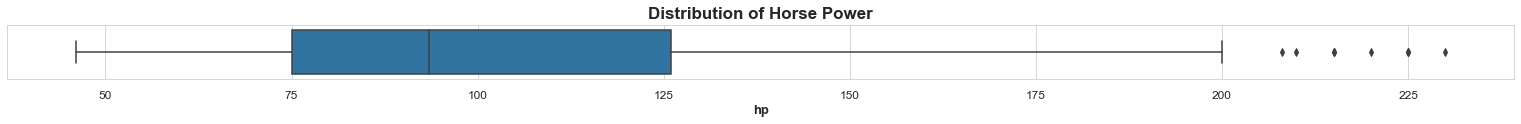

In [80]:
plt.figure(figsize = (27, 1))
sns.boxplot(x = "hp", data = dataset)

plt.title("Distribution of Horse Power")
plt.show()

The distribution shows that there are _few_ outliers. Firstly, these values can:
* _either be_ populated with the **_median_** (as [here](https://www.neenopal.com/dealing-with-outliers-and-missing-values-in-a-dataset.html)),
* _or_ we can check the correlation of the column and replace based on categories.

In [91]:
dataset = dataset.fillna({"hp" : dataset["hp"].median()}) # ? `inplace = True` is not working

**Note:** In the tutorial, there are `6` null values in `hp` column, but at the time of coding this is missing, and is thus ignored.

#### Categorical Columns

The `origin` is a categorical column. The column is thus "one-hot encoded" using the [`pd.get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) function.

In [60]:
origin = {1: "USA", 2: "EURO", 3: "JAP"}

dataset["origin"] = dataset["origin"].map(origin)
dataset = pd.get_dummies(dataset, columns = ["origin"], prefix = "", prefix_sep = "")

dataset.sample()

,mpg,cylinders,displacement,hp,wt,accelaration,year,EURO,JAP,USA
109,21.00,4,140.00,72.00,"2,401.00",19.50,73,0,0,1


In [61]:
# as we know this is a regression problem, thus normalization is necessary
# we should always normalize the data, before doing a train-test split to understand data range
scaler = StandardScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns = dataset.columns) # overwrite, as we do not require original data

In [62]:
train = dataset.sample(frac = 0.8, random_state = 7)
test = dataset.drop(train.index) # remove the index present in the training set

print(train.shape, test.shape) # show the data shape, i.e. no of records for analysis

(318, 10) (80, 10)


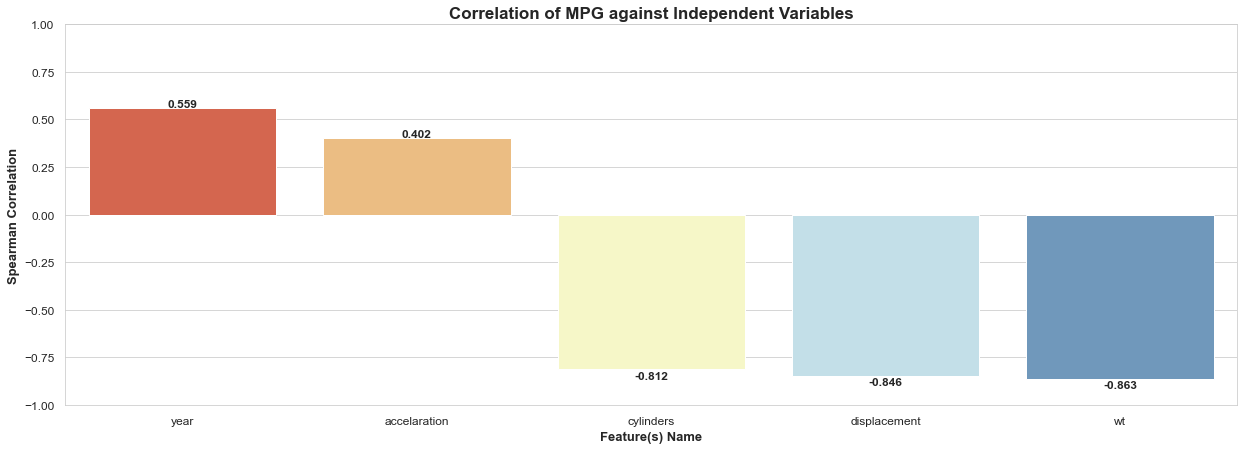

In [40]:
# using the `pd.corr()` to get the correlation, and extract the correlation of the fuel efficiency column
# convert the series `pd.corr()["column"]` to dataframe using `reset_index` command and finally, sort descending
# in addition, drop `index = 0` from `corr` as index = 0 will always given the correlation against self, thus rmeoved
corr = train.drop(columns = origin.values()) \
       .corr(method = "spearman").round(3)["mpg"].reset_index() \
       .drop(index = 0).sort_values(by = "mpg", ascending = False)

axs = sns.barplot(x = "index", y = "mpg", data = corr, palette = sns.color_palette("RdYlBu", corr.shape[0]).as_hex())

# also display the correlation values on the graph
# ? is `annot = True` available for `sns.barplot` model
corr = corr["mpg"].values # returns a ndarray
for tick in range(len(axs.get_xticklabels())):
    y_pos = corr[tick] + 5e-3 if corr[tick] > 0 else corr[tick] - 5e-2
    axs.text(tick, y_pos, str(corr[tick]), ha = "center", weight = "bold")

axs.set_ylim(-1, 1)
axs.set(xlabel = "Feature(s) Name")
axs.set(ylabel = "Spearman Correlation")

plt.title("Correlation of MPG against Independent Variables")
plt.show()

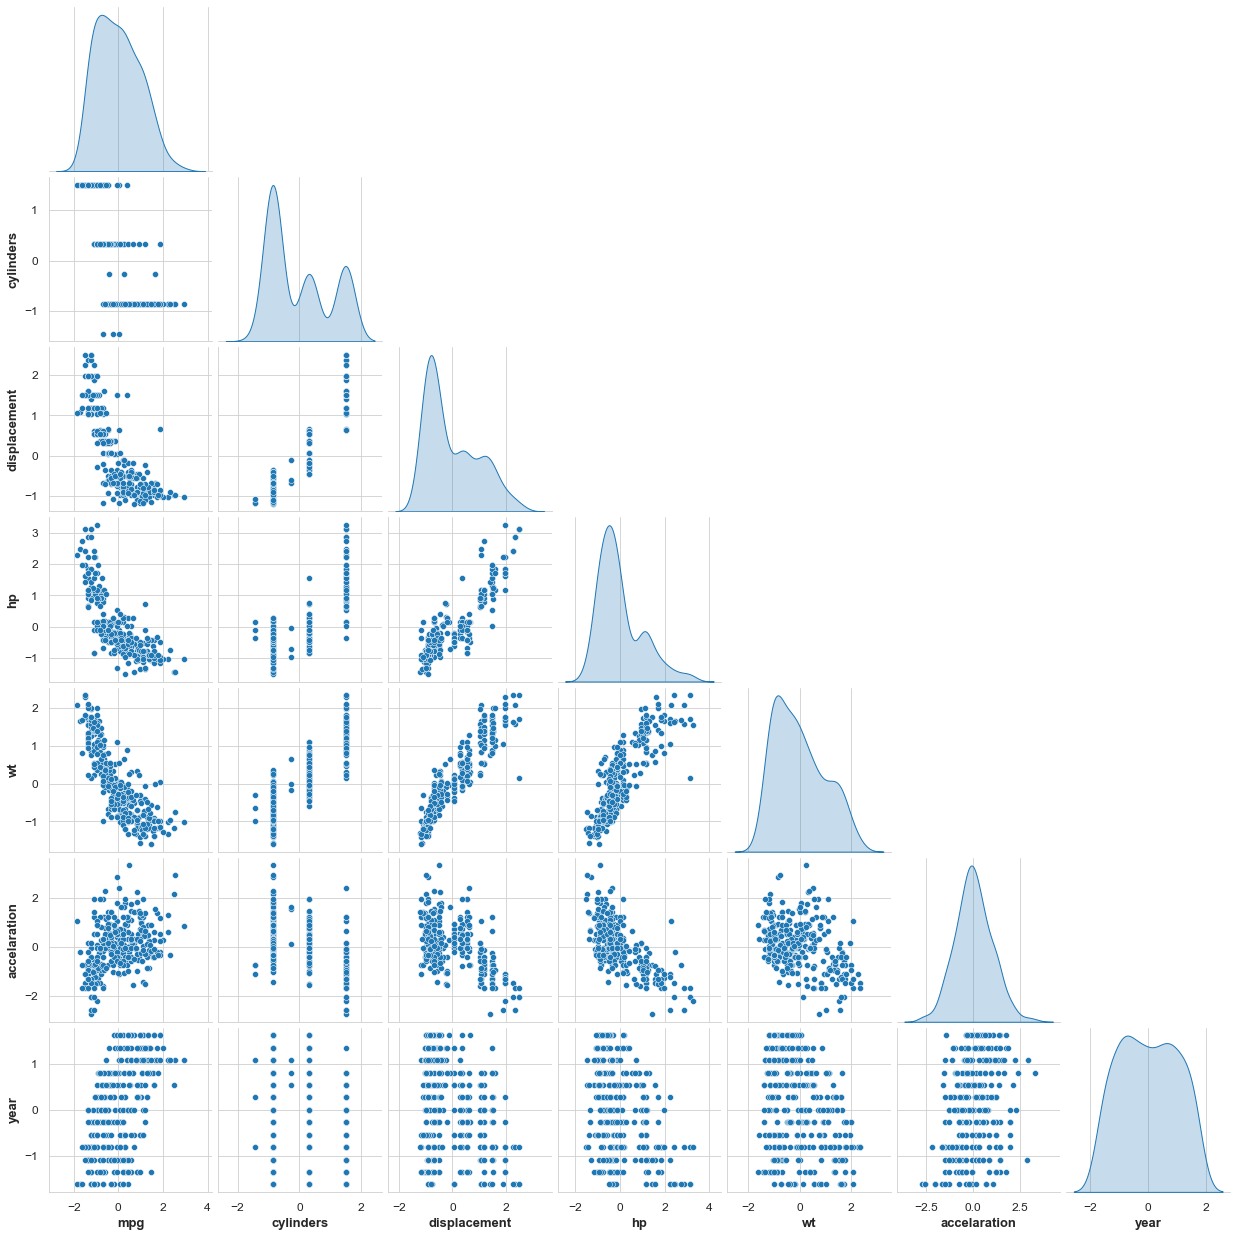

In [63]:
# instead of `sns.pairplot` using `sns.PairGrid` as it has more control
sns.pairplot(train.drop(columns = origin.values()), corner = True, diag_kind = "kde")

### Neural Network Model

<p align = "justify">An artificial neural network is designed to mimic the functioning of human brain. It consists of one input and one output layer, while there can be zero-to-many hidden layers. The optimal number of neurons in the first hidden layer is proposed by the <i>thumb rule</i>:</p>

$$
  N_h = a(N_i + N_o)
$$

where, $N_h$ is the number of neurons in hidden layer, $N_i$ and $N_o$ are the number of neurons in input and output layer respectively; and $a \in [2, 10]$ is an arbitrary scaling factor.

In [72]:
INPUT_SHAPE = train.drop(columns = ["mpg"]).shape[1] # no. of features
OUTPUT_SHAPE = 1 # as this is a regression problem

Nh = 2 * (INPUT_SHAPE + OUTPUT_SHAPE)
print(f"Proposed Optimal Number of Neurons on 1st Hidden Layer = {Nh}")

Proposed Optimal Number of Neurons on 1st Hidden Layer = 20


In [87]:
model = keras.Sequential([
    # sequential is a list of layers stacked one after the other in sequential manner
    # for the purpose of redability, each layer is named to avoid confusion, in addition
    # the layer defination is divided into three sections : `input`, `hidden` and `output`
    layers.Dense(
        Nh,
        input_shape = (INPUT_SHAPE, ),
        name = "input-layer"
    ),

    layers.BatchNormalization(name = "input-bn"),
    layers.Dropout(0.2, name = "input-dropouts"),

    # hidden layer section, by design, the first hidden layer is
    # defined under `input-layer`, and the rests are defined here
    # `encoder`-`decoder` logic follows the principle like `2 > 4 > 4 > 2`
    layers.Dense(Nh, name = "hl-01"),

    layers.BatchNormalization(name = "hl01-bn"),
    layers.Dropout(0.2, name = "hl01-dropouts"),

    # finally we define a output layer
    # this layer has neurons which are equal
    # to the number of output features/target
    layers.Dense(OUTPUT_SHAPE, name = "output-layer")
], name = "LinReg-v1.0.0")

model.summary(line_length = 127)

Model: "LinReg-v1.0.0"
_______________________________________________________________________________________________________________________________
 Layer (type)                                            Output Shape                                      Param #             
 input-layer (Dense)                                     (None, 20)                                        200                 
                                                                                                                               
 input-bn (BatchNormalization)                           (None, 20)                                        80                  
                                                                                                                               
 input-dropouts (Dropout)                                (None, 20)                                        0                   
                                                                                 

In [88]:
model.compile(optimizer = optimizers.Adam(learning_rate = 0.1), loss = "mean_absolute_error")

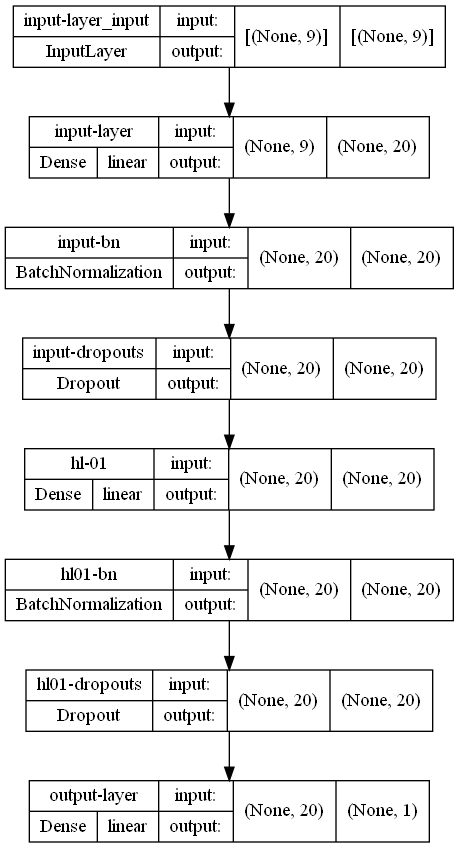

In [89]:
# in addition to line summary, we can also view the model using `plot` as:
# use `to_file = <filename>.<extension>` parameter to save the model image
keras.utils.plot_model(model, show_shapes = True, show_layer_activations = True)

In [90]:
history = model.fit(train.drop(columns = ["mpg"]), train["mpg"], epochs = 100, validation_split = 0.2, shuffle = True, verbose = 0)

In [92]:
pd.DataFrame(history.history)

,loss,val_loss
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
95,NaN,NaN
96,NaN,NaN
97,NaN,NaN
98,NaN,NaN
